In [14]:
import pandas as pd
import folium
import osmnx as ox
from shapely.geometry import LineString
from shapely.wkt import loads
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString, Polygon
from folium import PolyLine
import json

# import h3
from folium.plugins import HeatMap
from shapely.geometry import Polygon
import tqdm
from scipy.spatial import cKDTree
from shapely.geometry import Point
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from geopy.distance import geodesic

import networkx as nx
from shapely.wkt import loads
import math
from math import inf
from scipy.spatial import KDTree
from shapely.geometry import LineString

# Importing Data Overview

## 1. Data Loading:
   - Load spatial data from GeoPackage files (hexes, speed limit zones, parkings, forbidden zones).
   - Load additional data from CSV files (speed median, scooters at parkings, routes hex, road index, clashes).

## 2. Data Processing:
   - Merge different DataFrames based on common column values (e.g., merge hexes with routes_hex).

## 3. Geospatial Analysis:
   - Extract coordinates of nodes and edges from the loaded graph data.
   - Process and manipulate geospatial data, such as combining road attributes and splitting linestrings.
   - Assign corresponding hexagon values to roads based on the closest hexagon.

## 4. Graph Loading and Analysis:
   - Load or download a graph from OpenStreetMap (OSM) using a specified place name and filter expression.
   - Perform graph analysis on railway and subway crossings, retrieve graph information.


In [ ]:
# Open GeoPackage files
hexes = gpd.read_file("hexes (1).gpkg")
speed_limit_zones = gpd.read_file("speed_limit_zones (1).gpkg")
parkings = gpd.read_file("parkings (1).gpkg")
forbidden_zones = gpd.read_file("forbidden_zones (1).gpkg")


forbidden_zones
speed_limit_zones
# Open CSV files
speed_median = pd.read_csv("speed_median_hex20m_hackaton (1).csv")
scooters_at_parkings = pd.read_csv("scooters_at_parkings (1).csv")
routes_hex = pd.read_csv("routes_hex20m.csv")
road_index = pd.read_csv("road_index (1).csv")
clashes = pd.read_csv("clashes (1).csv")


# List of DataFrames
dfs = [
    hexes,
    speed_limit_zones,
    parkings,
    forbidden_zones,
    speed_median,
    scooters_at_parkings,
    routes_hex,
    road_index,
    clashes,
]  # Replace with your list of DataFrames

# Check and rename column "hex_id" to "id" in each DataFrame
for df in dfs:
    if "hex_id" in df.columns:
        df.rename(columns={"hex_id": "id"}, inplace=True)

routes_with_coords = pd.merge(hexes, routes_hex, on="id", how="inner")


routes_with_coordsANDclashes = pd.merge(
    routes_with_coords, clashes, on="id", how="left"
)

routes_with_coordsANDclashesANDroad = pd.merge(
    routes_with_coordsANDclashes, road_index, on="id", how="left"
)

routes_with_coordsANDclashesANDroadANDspeed = pd.merge(
    routes_with_coordsANDclashesANDroad, speed_median, on="id", how="left"
)

# Open GeoPackage files
hexes = gpd.read_file("hexes (1).gpkg")
speed_limit_zones = gpd.read_file("speed_limit_zones (1).gpkg")
parkings = gpd.read_file("parkings (1).gpkg")
forbidden_zones = gpd.read_file("forbidden_zones (1).gpkg")

# Open CSV files
speed_median = pd.read_csv("speed_median_hex20m_hackaton (1).csv")
scooters_at_parkings = pd.read_csv("scooters_at_parkings (1).csv")
routes_hex = pd.read_csv("routes_hex20m.csv")
road_index = pd.read_csv("road_index (1).csv")
clashes = pd.read_csv("clashes (1).csv")


# List of DataFrames
dfs = [
    hexes,
    speed_limit_zones,
    parkings,
    forbidden_zones,
    speed_median,
    scooters_at_parkings,
    routes_hex,
    road_index,
    clashes,
]  # Replace with your list of DataFrames

# Check and rename column "hex_id" to "id" in each DataFrame
for df in dfs:
    if "hex_id" in df.columns:
        df.rename(columns={"hex_id": "id"}, inplace=True)

routes_with_coords = pd.merge(hexes, routes_hex, on="id", how="inner")


routes_with_coordsANDclashes = pd.merge(
    routes_with_coords, clashes, on="id", how="left"
)

routes_with_coordsANDclashesANDroad = pd.merge(
    routes_with_coordsANDclashes, road_index, on="id", how="left"
)

routes_with_coordsANDclashesANDroadANDspeed = pd.merge(
    routes_with_coordsANDclashesANDroad, speed_median, on="id", how="left"
)


place_name = "Moscow, Russia"
graph_fp = "static/graphs/moscow.graphml"

# Загрузка или загрузка и кэширование графа из OSM
cf = '["highway"~"path|track|footway|steps|bridleway|cycleway|pedestrian|cycleway=shared_lane|cycleway=lane|cycleway=opposite|cycleway=opposite_lane|cycleway=segregated|cycleway:left|cycleway:right|cycleway:both|cycleway:left:shared_lane|cycleway:right:shared_lane|cycleway:both:shared_lane|cycleway=track|tracktype=grade1|tracktype=grade2|tracktype=grade3|service=driveway|service=alley|service=drive-through|service=parking_aisle|service=emergency_access"]'

G = ox.graph_from_place(place_name, custom_filter=cf)
ox.save_graphml(G, graph_fp)

# Загрузка графа из кэша
G = ox.load_graphml(graph_fp)

# Загрузка графа из кэша
G = ox.load_graphml(graph_fp)

# Получение координат узлов графа
nodes, edges = ox.graph_to_gdfs(G)

edges_df = gpd.GeoDataFrame(edges)
combined_roads = (
    edges_df.reset_index()[["highway", "geometry", "name", "landuse"]]
    .dropna(subset=["highway", "geometry"])
    .apply(lambda x: "; ".join(x.dropna().astype(str)), axis=1)
)


combined_roads = pd.DataFrame(combined_roads)
combined_roads[["type", "geometry"]] = combined_roads[0].str.split(
    ";", n=1, expand=True
)
combined_roads = combined_roads.drop(0, axis=1)


nodes_df = gpd.GeoDataFrame(nodes)
combined_nodes = (
    nodes_df.reset_index()[["osmid", "x", "y", "geometry"]]
    .dropna(subset=["osmid", "geometry"])
    .apply(lambda x: "; ".join(x.dropna().astype(str)), axis=1)
)

combined_nodes = pd.DataFrame(combined_nodes)
combined_nodes[["osmid", "x", "y", "geometry"]] = combined_nodes[0].str.split(
    ";", n=3, expand=True
)
combined_nodes = combined_nodes.drop(0, axis=1)

combined_roads["geometry"] = combined_roads["geometry"].apply(
    lambda geom_str: loads(geom_str)
)
combined_roads["x"] = combined_roads["geometry"].apply(lambda geom: geom.coords[0][0])
combined_roads["y"] = combined_roads["geometry"].apply(lambda geom: geom.coords[0][1])
combined_roads["sum"] = combined_roads["x"] + combined_roads["y"]

sorted_hexagons = routes_with_coordsANDclashesANDroadANDspeed
sorted_hexagons["centroid"] = sorted_hexagons["geometry"].apply(
    lambda polygon: polygon.centroid
)
sorted_hexagons["centroid_x"] = sorted_hexagons["geometry"].centroid.x
sorted_hexagons = sorted_hexagons.sort_values(by="centroid_x")
sorted_hexagons["centroid_y"] = sorted_hexagons["geometry"].centroid.y
sorted_hexagons["centroid"] = sorted_hexagons["centroid"].apply(
    lambda geom: Point(geom.x, geom.y)
)

# sorted_hexagons['centroid'] = sorted_hexagons['centroid'].apply(lambda geom: Point(geom.x, geom.y))

# min_x = sorted_hexagons['centroid'].apply(lambda point: point.x).min()
# min_y = sorted_hexagons['centroid'].apply(lambda point: point.y).min()
# max_x = sorted_hexagons['centroid'].apply(lambda point: point.x).max()
# max_y = sorted_hexagons['centroid'].apply(lambda point: point.y).max()
# bbox = box(min_x, min_y, max_x, max_y)
# combined_roads = combined_roads[combined_roads['geometry'].apply(lambda line: line.within(bbox))]


def split_linestring(line):
    if line.geom_type == "LineString" and len(line.coords) > 2:
        segments = []
        for i in range(len(line.coords) - 1):
            segment = LineString([line.coords[i], line.coords[i + 1]])
            segments.append(segment)
        return segments
    return line


combined_roads["geometry"] = combined_roads["geometry"].apply(split_linestring)
combined_roads = combined_roads.explode("geometry").reset_index(drop=True)
sorted_hexagons["centroid_sum"] = sorted_hexagons["centroid"].apply(
    lambda centroid: centroid.x + centroid.y
)


from shapely.geometry import Point, LineString
import numpy as np
from scipy.spatial import cKDTree

hexagons = sorted_hexagons


def find_closest_hexagon(hexagons, road_points, hexagon_values):
    # Build a KDTree for hexagon centroids
    kdtree = cKDTree(hexagons)

    # Find the closest hexagon for each road point
    _, idx = kdtree.query(road_points)

    # Retrieve the corresponding hexagon values
    closest_hexagon_values = hexagon_values[idx]

    return closest_hexagon_values


# Convert hexagon centroids to numpy array
hexagon_points = np.array(list(zip(hexagons["centroid_x"], hexagons["centroid_y"])))

# Convert road points to numpy array
road_points = np.array(list(zip(combined_roads["x"], combined_roads["y"])))

# Convert hexagon values to numpy array
hexagon_values = np.array(
    hexagons[
        [
            "route_sum",
            "clashes_share",
            "clash_power_median",
            "ri_median",
            "speed_median",
        ]
    ]
)

# Find the closest hexagon for each road point
closest_hexagon_values = find_closest_hexagon(
    hexagon_points, road_points, hexagon_values
)

# Assign the closest hexagon values to the roads dataframe
combined_roads[
    ["route_sum", "clashes_share", "clash_power_median", "ri_median", "speed_median"]
] = closest_hexagon_values

place_name = "Moscow, Russia"
graph_fp = "static/graphs/moscow.graphml"

# Define the filter expression for pedestrian and subway crossings
cf_railway = '["railway"~"subway_entrance|subway|crossing"]'
cf_subway = '["highway"~"footway|steps|pedestrian"]'

# Load or download and cache the graph from OSM with the specified filter for railway crossings
G_railway = ox.graph_from_place(place_name, custom_filter=cf_railway)
ox.save_graphml(G_railway, graph_fp)

# Load or download and cache the graph from OSM with the specified filter for subway crossings
G_subway = ox.graph_from_place(place_name, custom_filter=cf_subway)
ox.save_graphml(G_subway, graph_fp)

# Load the graph for railway crossings from the cache
G_railway = ox.load_graphml(graph_fp)

# Load the graph for subway crossings from the cache
G_subway = ox.load_graphml(graph_fp)

# Print some information about the railway crossings graph
print("Railway Crossings Graph Information:")
print(f"Number of nodes: {len(G_railway.nodes)}")
print(f"Number of edges: {len(G_railway.edges)}")

# Print some information about the subway crossings graph
print("\nSubway Crossings Graph Information:")
print(f"Number of nodes: {len(G_subway.nodes)}")
print(f"Number of edges: {len(G_subway.edges)}")


nodes_railway, edges_railway = ox.graph_to_gdfs(G_railway)
nodes_subway, edges_subway = ox.graph_to_gdfs(G_subway)


import geopandas as gpd
import pandas as pd
from shapely.wkt import loads

edges_df_railway = gpd.GeoDataFrame(edges_railway)
combined_roads_railway = (
    edges_df_railway.reset_index()[["highway", "geometry", "name", "landuse"]]
    .dropna(subset=["highway", "geometry"])
    .apply(lambda x: "; ".join(x.dropna().astype(str)), axis=1)
)

combined_roads_railway = pd.DataFrame(combined_roads_railway)
combined_roads_railway[["type", "geometry"]] = combined_roads_railway[0].str.split(
    ";", n=1, expand=True
)
combined_roads_railway = combined_roads_railway.drop(0, axis=1)

nodes_df_railway = gpd.GeoDataFrame(nodes_railway)
combined_nodes_railway = (
    nodes_df_railway.reset_index()[["osmid", "x", "y", "geometry"]]
    .dropna(subset=["osmid", "geometry"])
    .apply(lambda x: "; ".join(x.dropna().astype(str)), axis=1)
)

combined_nodes_railway = pd.DataFrame(combined_nodes_railway)
combined_nodes_railway[["osmid", "x", "y", "geometry"]] = combined_nodes_railway[
    0
].str.split(";", n=3, expand=True)
combined_nodes_railway = combined_nodes_railway.drop(0, axis=1)

combined_roads_railway["geometry"] = combined_roads_railway["geometry"].apply(
    lambda geom_str: loads(geom_str)
)
combined_roads_railway["x"] = combined_roads_railway["geometry"].apply(
    lambda geom: geom.coords[0][0]
)
combined_roads_railway["y"] = combined_roads_railway["geometry"].apply(
    lambda geom: geom.coords[0][1]
)
combined_roads_railway["sum"] = (
    combined_roads_railway["x"] + combined_roads_railway["y"]
)

edges_df_subway = gpd.GeoDataFrame(edges_subway)
combined_roads_subway = (
    edges_df_subway.reset_index()[["highway", "geometry", "name", "landuse"]]
    .dropna(subset=["highway", "geometry"])
    .apply(lambda x: "; ".join(x.dropna().astype(str)), axis=1)
)

combined_roads_subway = pd.DataFrame(combined_roads_subway)
combined_roads_subway[["type", "geometry"]] = combined_roads_subway[0].str.split(
    ";", n=1, expand=True
)
combined_roads_subway = combined_roads_subway.drop(0, axis=1)

nodes_df_subway = gpd.GeoDataFrame(nodes_subway)
combined_nodes_subway = (
    nodes_df_subway.reset_index()[["osmid", "x", "y", "geometry"]]
    .dropna(subset=["osmid", "geometry"])
    .apply(lambda x: "; ".join(x.dropna().astype(str)), axis=1)
)

combined_nodes_subway = pd.DataFrame(combined_nodes_subway)
combined_nodes_subway[["osmid", "x", "y", "geometry"]] = combined_nodes_subway[
    0
].str.split(";", n=3, expand=True)
combined_nodes_subway = combined_nodes_subway.drop(0, axis=1)


combined_roads_subway["geometry"] = combined_roads_subway["geometry"].apply(
    lambda geom_str: loads(geom_str)
)
combined_roads_subway["x"] = combined_roads_subway["geometry"].apply(
    lambda geom: geom.coords[0][0]
)
combined_roads_subway["y"] = combined_roads_subway["geometry"].apply(
    lambda geom: geom.coords[0][1]
)
combined_roads_subway["sum"] = combined_roads_subway["x"] + combined_roads_subway["y"]

import numpy as np
from scipy.spatial import cKDTree
from shapely.geometry import Point

hexagons = sorted_hexagons


def find_closest_hexagon(hexagons, road_points, hexagon_values):
    # Build a KDTree for hexagon centroids
    kdtree = cKDTree(hexagons)

    # Find the closest hexagon for each road point
    _, idx = kdtree.query(road_points)

    # Retrieve the corresponding hexagon values
    closest_hexagon_values = hexagon_values[idx]

    return closest_hexagon_values


# Convert hexagon centroids to numpy array
hexagon_points = np.array(list(zip(hexagons["centroid_x"], hexagons["centroid_y"])))

# Convert road points to numpy array
road_points_railway = np.array(
    list(zip(combined_roads_railway["x"], combined_roads_railway["y"]))
)
road_points_subway = np.array(
    list(zip(combined_roads_subway["x"], combined_roads_subway["y"]))
)

# Convert hexagon values to numpy array
hexagon_values = np.array(
    hexagons[
        [
            "route_sum",
            "clashes_share",
            "clash_power_median",
            "ri_median",
            "speed_median",
        ]
    ]
)

# Find the closest hexagon for each road point in railway graph
closest_hexagon_values_railway = find_closest_hexagon(
    hexagon_points, road_points_railway, hexagon_values
)

# Find the closest hexagon for each road point in subway graph
closest_hexagon_values_subway = find_closest_hexagon(
    hexagon_points, road_points_subway, hexagon_values
)

# Assign the closest hexagon values to the railway roads dataframe
combined_roads_railway[
    ["route_sum", "clashes_share", "clash_power_median", "ri_median", "speed_median"]
] = closest_hexagon_values_railway

# Assign the closest hexagon values to the subway roads dataframe
combined_roads_subway[
    ["route_sum", "clashes_share", "clash_power_median", "ri_median", "speed_median"]
] = closest_hexagon_values_subway

df = pd.read_csv("all_roads.csv")

from tqdm import tqdm
from shapely import wkt
from shapely.geometry import Point, LineString

# Convert string geometries to Shapely geometry objects
df["geometry"] = df["geometry"].apply(wkt.loads)

# Создаем пустой список для хранения значений 'forbidden'
forbidden_values = []

# Проходим по каждой строке в df с использованием tqdm для отображения прогресса
for index, row in tqdm(df.iterrows(), total=len(df)):
    linestring_geom = row["geometry"]
    # Переменная для хранения значения 'forbidden' по умолчанию (0)
    forbidden_value = 0

    # Преобразуем каждую вершину линии в точку и проверяем, что она не находится внутри полигона
    for _, zone_row in forbidden_zones.iterrows():
        polygon_geom = zone_row["geometry"]
        points_within_polygon = [
            Point(point) for point in linestring_geom.coords
        ]  # Convert each tuple coordinate to a Point object
        if any(point.within(polygon_geom) for point in points_within_polygon):
            # Если хотя бы одна вершина находится внутри полигона, считаем линию запрещенной
            forbidden_value = zone_row["schedule"]
            break

    forbidden_values.append(forbidden_value)

df["forbidden"] = forbidden_values

The algorithm aims to fill missing values in a DataFrame (`df`) using decision tree models. It follows these steps:

1. **Prepare data**:
   - Create a copy of the DataFrame with non-null values for the target column.
   - Separate the features and the target variable.

2. **Find best hyperparameters**:
   - Perform a grid search with cross-validation to find the optimal hyperparameters for the decision tree model.
   - Use a scoring metric such as mean squared error.

3. **Train the best model**:
   - Retrieve the best model from the grid search results.

4. **Fill missing values**:
   - Select rows with missing values for a specific column.
   - Predict the missing values using the trained model and the remaining features.
   - Replace the predicted values in the original DataFrame.

5. **Repeat steps 2-4** for each column with missing values.

This algorithm fills missing values in `df` using decision tree models. Each column is treated independently. The missing values are predicted based on the other available features.


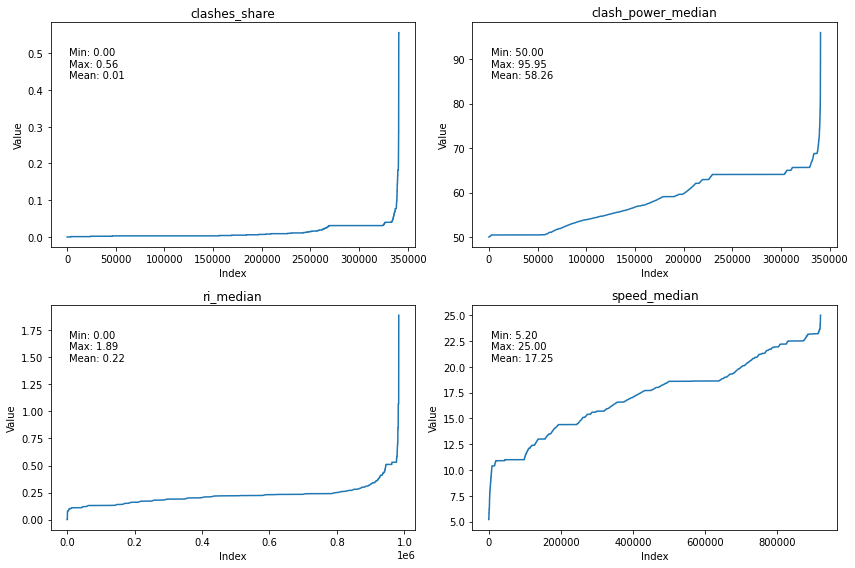

In [10]:
columns = ["clashes_share", "clash_power_median", "ri_median", "speed_median"]
df = pd.read_csv("all_roads.csv")
df = df.drop(columns="Unnamed: 0")

# Создание подложки для графиков
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Построение графиков
for i, column in enumerate(columns):
    # Сортировка значений столбца
    sorted_values = df[column].sort_values().reset_index(drop=True)

    # Номер строки и столбца текущего графика
    row = i // 2
    col = i % 2

    # Построение графика
    axes[row, col].plot(sorted_values)
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("Index")
    axes[row, col].set_ylabel("Value")

    # Добавление примечания с минимальным, максимальным и средним значением
    axes[row, col].annotate(
        f"Min: {sorted_values.min():.2f}\nMax: {sorted_values.max():.2f}\nMean: {sorted_values.mean():.2f}",
        xy=(0.05, 0.75),
        xycoords="axes fraction",
        fontsize=10,
    )

# Размещение графиков
plt.tight_layout()
plt.show()

In [4]:
# Создание DataFrame для OHE
df = pd.read_csv("all_roads.csv")
df = df.drop(columns="Unnamed: 0")

df_encoded = pd.DataFrame()

# Список категорий для OHE
categories = [
    "footway",
    "steps",
    "path",
    "track",
    "cycleway",
    "pedestrian",
    "bridleway",
]

# Добавление столбцов с нулями
for category in categories:
    df_encoded[category] = 0

# Установка значений 1
for category in categories:
    df_encoded[category] = df["type"].apply(lambda x: 1 if category in x else 0)
df_encoded = df_encoded.fillna(0)

# Добавление полученного DataFrame к изначальному DataFrame
df = pd.concat([df, df_encoded], axis=1)

df["geometry"] = df["geometry"].apply(loads)
df.drop(columns="type", inplace=True)
# Создайте новый столбец 'length' и вычислите длину каждого LineString
df["length"] = df["geometry"].apply(lambda geom: geom.length)

df = df.drop(columns="geometry")

df_for_cat = df[df["ri_median"].notnull()].copy()

# Разделение на признаки и целевую переменную
X = df_for_cat.drop(
    columns=["clashes_share", "clash_power_median", "speed_median", "ri_median"]
)
y = df_for_cat["ri_median"]

# Определение параметров для GridSearch
param_grid = {"min_samples_split": [6], "min_samples_leaf": [4]}

# Создание модели DecisionTreeRegressor
model = DecisionTreeRegressor()

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

# Выполнение GridSearchCV
grid_search.fit(X, y)

# Получение результатов GridSearchCV
results = grid_search.cv_results_
mean_scores = -results["mean_test_score"]
params = results["params"]

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Вывод параметров и соответствующих значений MSE
for param, score in zip(params, mean_scores):
    print("Parameters:", param)
    print("MSE:", score)
    print("_________________________")

# Обучение лучшей модели на полных данных
best_model.fit(X, y)

# Выбор строк, где 'ri_median' равен None
rows_with_none = df[df["ri_median"].isna()]

rows_with_none = rows_with_none.drop(
    columns=["clashes_share", "clash_power_median", "speed_median"]
)

# Предсказание значений для столбца 'ri_median' на выбранных строках
predicted_values = best_model.predict(rows_with_none.drop("ri_median", axis=1))

# Запись предсказанных значений обратно в DataFrame
df.loc[df["ri_median"].isna(), "ri_median"] = predicted_values

df_for_cat1 = df[df["speed_median"].notnull()].copy()

# Разделение на признаки и целевую переменную
X = df_for_cat1.drop(columns=["clashes_share", "clash_power_median", "speed_median"])
y = df_for_cat1["speed_median"]

# Определение параметров для GridSearch
param_grid = {"min_samples_split": [6], "min_samples_leaf": [4]}

# Создание модели DecisionTreeRegressor
model = DecisionTreeRegressor()

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

# Выполнение GridSearchCV
grid_search.fit(X, y)

# Получение результатов GridSearchCV
results = grid_search.cv_results_
mean_scores = -results["mean_test_score"]
params = results["params"]

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Вывод параметров и соответствующих значений MSE
for param, score in zip(params, mean_scores):
    print("Parameters:", param)
    print("MSE:", score)
    print("_________________________")

# Обучение лучшей модели на полных данных
best_model.fit(X, y)

# Выбор строк, где 'ri_median' равен None
rows_with_none = df[df["speed_median"].isna()]

rows_with_none = rows_with_none.drop(columns=["clashes_share", "clash_power_median"])

# Предсказание значений для столбца 'ri_median' на выбранных строках
predicted_values = best_model.predict(rows_with_none.drop("speed_median", axis=1))

# Запись предсказанных значений обратно в DataFrame
df.loc[df["speed_median"].isna(), "speed_median"] = predicted_values

df_for_cat2 = df[df["clashes_share"].notnull()].copy()

# Разделение на признаки и целевую переменную
X = df_for_cat2.drop(columns=["clash_power_median", "clashes_share"])
y = df_for_cat2["clashes_share"]

# Определение параметров для GridSearch
param_grid = {"min_samples_split": [6], "min_samples_leaf": [3]}

# Создание модели DecisionTreeRegressor
model = DecisionTreeRegressor()

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

# Выполнение GridSearchCV
grid_search.fit(X, y)

# Получение результатов GridSearchCV
results = grid_search.cv_results_
mean_scores = -results["mean_test_score"]
params = results["params"]

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Вывод параметров и соответствующих значений MSE
for param, score in zip(params, mean_scores):
    print("Parameters:", param)
    print("MSE:", score)
    print("_________________________")

# Обучение лучшей модели на полных данных
best_model.fit(X, y)

# Выбор строк, где 'ri_median' равен None
rows_with_none = df[df["clashes_share"].isna()]

rows_with_none = rows_with_none.drop(columns=["clash_power_median"])

# Предсказание значений для столбца 'ri_median' на выбранных строках
predicted_values = best_model.predict(rows_with_none.drop("clashes_share", axis=1))

# Запись предсказанных значений обратно в DataFrame
df.loc[df["clashes_share"].isna(), "clashes_share"] = predicted_values

Parameters: {'min_samples_leaf': 4, 'min_samples_split': 6}
MSE: 14.33791193578627
_________________________


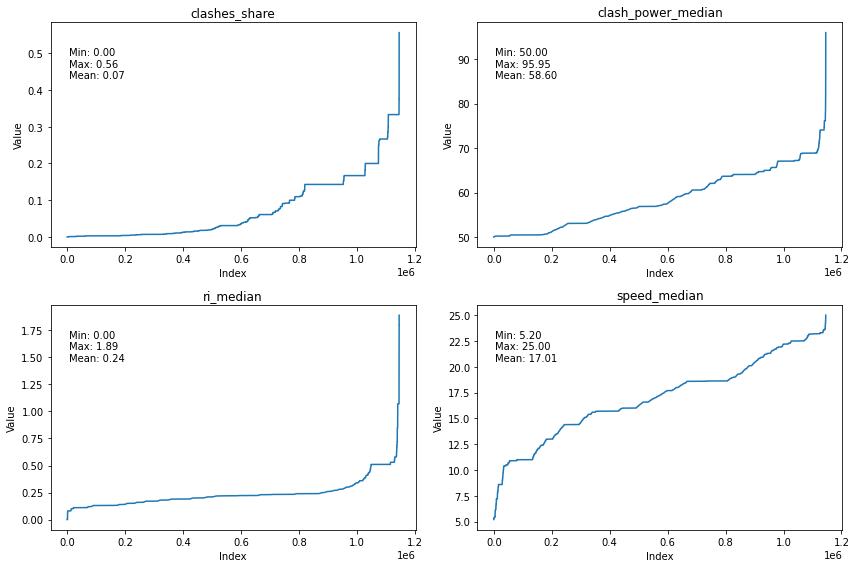

In [9]:
df_for_cat3 = df[df["clash_power_median"].notnull()].copy()

# Разделение на признаки и целевую переменную
X = df_for_cat2.drop(columns=["clash_power_median"])
y = df_for_cat2["clash_power_median"]

# Определение параметров для GridSearch
param_grid = {"min_samples_split": [6], "min_samples_leaf": [4]}

# Создание модели DecisionTreeRegressor
model = DecisionTreeRegressor()

# Создание объекта GridSearchCV
grid_search = GridSearchCV(
    estimator=model, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error"
)

# Выполнение GridSearchCV
grid_search.fit(X, y)

# Получение результатов GridSearchCV
results = grid_search.cv_results_
mean_scores = -results["mean_test_score"]
params = results["params"]

# Получение лучшей модели
best_model = grid_search.best_estimator_

# Вывод параметров и соответствующих значений MSE
for param, score in zip(params, mean_scores):
    print("Parameters:", param)
    print("MSE:", score)
    print("_________________________")

# Обучение лучшей модели на полных данных
best_model.fit(X, y)

# Выбор строк, где 'ri_median' равен None
rows_with_none = df[df["clash_power_median"].isna()]

# Предсказание значений для столбца 'ri_median' на выбранных строках
predicted_values = best_model.predict(rows_with_none.drop("clash_power_median", axis=1))

# Запись предсказанных значений обратно в DataFrame
df.loc[df["clash_power_median"].isna(), "clash_power_median"] = predicted_values


# Список столбцов для построения графиков
columns = ["clashes_share", "clash_power_median", "ri_median", "speed_median"]

# Создание подложки для графиков
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Построение графиков
for i, column in enumerate(columns):
    # Сортировка значений столбца
    sorted_values = df[column].sort_values().reset_index(drop=True)

    # Номер строки и столбца текущего графика
    row = i // 2
    col = i % 2

    # Построение графика
    axes[row, col].plot(sorted_values)
    axes[row, col].set_title(column)
    axes[row, col].set_xlabel("Index")
    axes[row, col].set_ylabel("Value")

    # Добавление примечания с минимальным, максимальным и средним значением
    axes[row, col].annotate(
        f"Min: {sorted_values.min():.2f}\nMax: {sorted_values.max():.2f}\nMean: {sorted_values.mean():.2f}",
        xy=(0.05, 0.75),
        xycoords="axes fraction",
        fontsize=10,
    )

# Размещение графиков
plt.tight_layout()
plt.show()

In [10]:
forbidden = pd.read_csv("temp.csv")
df["forbidden"] = forbidden["forbidden"]

geom = pd.read_csv("all_roads.csv")
df["geometry"] = geom["geometry"]

In [ ]:
import pandas as pd
from geopy.distance import geodesic

import networkx as nx
from shapely.wkt import loads
import math
from math import inf
from scipy.spatial import KDTree
from shapely.geometry import LineString

# Iterate over each row in the DataFrame
for index, row in roads.iterrows():
    # Extract the geometry string
    geometry_str = row["geometry"]

    # Extract the coordinates from the geometry string
    coordinates = geometry_str.replace("LINESTRING (", "").replace(")", "").split(", ")
    points = [tuple(map(float, coord.split())) for coord in coordinates]

    # Create a ShaЮpely LineString object
    linestring = LineString(points)

    # Update the 'geometry' column with the LineString object
    roads.at[index, "geometry"] = linestring


from shapely.geometry import LineString
from geopy.distance import geodesic

# Iterate over each row in the DataFrame
for index, row in roads.iterrows():
    # Extract the LineString geometry
    linestring = row["geometry"]

    # Extract the coordinates from the LineString
    coordinates = list(linestring.coords)

    # Calculate the distance between the first and last points in kilometers
    distance = geodesic(coordinates[0], coordinates[-1]).kilometers

    # Update the 'distance' column with the calculated distance
    roads.at[index, "distance"] = distance


roads.drop(columns=["length", "Unnamed: 0"], inplace=True)
roads.rename(columns={"distance": "length"}, inplace=True)

In [14]:
parkings_with_scooters = pd.read_csv("parkings_with_coords.csv")

# То, где может передвигаться пешеход
def len_for_pedestr(
    length, steps, bridleway, pedestrian, footway, path, cycleway, track
):
    if footway == 1 or path == 1:
        return length
    elif steps == 1 or pedestrian == 1 or bridleway == 1:
        if cycleway == 1 or track == 1:
            return float(inf)
        else:
            return length
    else:
        return float(inf)


# предполагаем, что средняя скорость пешехода 5 км/ч
def time_on_road_pedestr(len_for_pedestr, steps, bridleway, pedestrian):
    if steps == 1 or bridleway == 1 or pedestrian == 1:
        return len_for_pedestr / 4.5
    else:
        return len_for_pedestr / 5


def time_on_road_scooter(length, speed, steps, bridleway, pedestrian):
    if steps == 1 or bridleway == 1 or pedestrian == 1:
        return length / speed + 2 / 60
    else:
        return length / speed


def inconvenience_for_pedestr(
    len_for_pedestr, steps, bridleway, pedestrian, road_index, popularity
):
    coef_stops = (
        1 + sum([steps, pedestrian, bridleway]) / 3
    )  # штраф за переходы, лестницы
    coef_road_ind = 1 + 0.5 * road_index  # штраф за качество дорожного покрытия
    coef_popular = 1 + math.sqrt(popularity)  # штраф за популярность среди самокатов
    return len_for_pedestr * coef_stops * coef_road_ind * coef_popular


def inconvenience_for_scooter(
    length,
    cycleway,
    footway,
    path,
    track,
    steps,
    bridleway,
    pedestrian,
    road_index,
    popularity,
    clash_power,
):
    coef_clash_power = 1 + (clash_power - 50) / 100  # штраф за удары колеса
    coef_popular = 1 - math.sqrt(popularity)  # награда за популярность
    coef_foot = 1 + 4 * sum([steps, pedestrian, bridleway]) / 3  # штраф за спешивание
    coef_road_ind = 1 + road_index  # штраф за качество дорожного покрытия

    return length * coef_clash_power * coef_popular * coef_foot * coef_road_ind


roads["len_for_pedestr"] = roads.apply(
    lambda row: len_for_pedestr(
        row["length"],
        row["steps"],
        row["bridleway"],
        row["pedestrian"],
        row["footway"],
        row["path"],
        row["cycleway"],
        row["track"],
    ),
    axis=1,
)

roads["time_pedestr"] = roads.apply(
    lambda row: time_on_road_pedestr(
        row["len_for_pedestr"], row["steps"], row["bridleway"], row["pedestrian"]
    ),
    axis=1,
)

roads["time_scooter"] = roads.apply(
    lambda row: time_on_road_scooter(
        row["length"],
        row["speed_median"],
        row["steps"],
        row["bridleway"],
        row["pedestrian"],
    ),
    axis=1,
)

roads["inconvenience_pedestr"] = roads.apply(
    lambda row: inconvenience_for_pedestr(
        row["len_for_pedestr"],
        row["steps"],
        row["bridleway"],
        row["pedestrian"],
        row["ri_median"],
        row["route_sum"],
    ),
    axis=1,
)

roads["inconvenience_scooter"] = roads.apply(
    lambda row: inconvenience_for_scooter(
        row["length"],
        row["cycleway"],
        row["footway"],
        row["path"],
        row["track"],
        row["steps"],
        row["bridleway"],
        row["pedestrian"],
        row["ri_median"],
        row["route_sum"],
        row["clash_power_median"],
    ),
    axis=1,
)

In [15]:
# Создаем пустой граф
graph = nx.Graph()

# # Для ориентированного графа
# graph = nx.DiGraph()

# Обрабатываем каждую дорогу
for ind, road in roads.head(1000).iterrows():
    # Признаки дороги
    road_geometry = road["geometry"]  # Координаты конца и начала дороги
    len_for_pedestr = road["len_for_pedestr"]
    length = road["length"]
    time_pedestr = road["time_pedestr"]
    time_scooter = road["time_scooter"]
    inconvenience_pedestr = road["inconvenience_pedestr"]
    inconvenience_scooter = road["inconvenience_scooter"]

    # Извлекаем координаты вершин из строки LINESTRING
    coordinates = list(road_geometry.coords)

    # Добавляем вершины в граф
    for coordinate in coordinates:
        graph.add_node(coordinate, is_parking=False, scooters_count=0)

    # Добавляем ребра между вершинами
    s = coordinates[0]
    f = coordinates[1]
    graph.add_edge(
        s,
        f,
        length=length,
        len_for_pedestr=len_for_pedestr,
        time_pedestr=time_pedestr,
        time_scooter=time_scooter,
        inconvenience_pedestr=inconvenience_pedestr,
        inconvenience_scooter=inconvenience_scooter,
    )

#     road_length = geodesic(s, f).kilometers  # Длина дороги

In [16]:
med_len = roads["length"].median()
med_len_ped = roads["len_for_pedestr"].median()
med_time_ped = roads["time_pedestr"].median()
med_time_scoot = roads["time_scooter"].median()
med_inconv_ped = roads["inconvenience_pedestr"].median()
med_inconv_scoot = roads["inconvenience_scooter"].median()

In [17]:
parkings_with_scooters = parkings_with_scooters.drop("Unnamed: 0", axis=1)

parkings_with_scooters.drop_duplicates(inplace=True)


# from shapely.geometry import Point

# # Iterate over each row in the DataFrame
# for index, row in parkings_with_scooters.iterrows():
#     # Extract the geometry string
#     geometry_str = row['geometry']

#     # Extract the coordinates from the geometry string
#     lon, lat = map(float, geometry_str.replace('POINT (', '').replace(')', '').split())

#     # Create a Shapely Point object
#     point = Point(lon, lat)

#     # Update the 'geometry' column with the Point object
#     parkings_with_scooters.at[index, 'geometry'] = point


from shapely.geometry import Point

for ind, parking in parkings_with_scooters.iterrows():
    parking_geometry = parking["geometry"]

    #     # Create a Point object from the parking_geometry
    #     point = Point(parking_geometry.x, parking_geometry.y)
    #     # Extract the coordinates from the Point object
    #     lon = point.x
    #     lat = point.y

    # Extract the coordinates from the geometry string
    lon, lat = map(
        float, parking_geometry.replace("POINT (", "").replace(")", "").split()
    )
    graph.add_node(
        (lon, lat), is_parking=True, scooters_count=parking["scooters_at_parking"]
    )


def find_nearest_road(graph, point):
    road_nodes = [
        node
        for node, attrs in graph.nodes(data=True)
        if not attrs.get("is_parking", False)
    ]
    road_node_coords = [(node[0], node[1]) for node in road_nodes]

    kdtree = KDTree(road_node_coords)
    _, nearest_node_index = kdtree.query([point[0], point[1]])
    nearest_road = road_nodes[nearest_node_index]

    return nearest_road


isolated_nodes = [node for node, degree in graph.degree() if degree == 0]

for node in isolated_nodes:
    nearest_road = find_nearest_road(graph, node)
    graph.add_edge(
        node,
        nearest_road,
        length=med_len,
        len_for_pedestr=med_len_ped,
        time_pedestr=med_time_ped,
        time_scooter=med_time_scoot,
        inconvenience_pedestr=med_inconv_ped,
        inconvenience_scooter=med_inconv_scoot,
    )

In [65]:
# Check attribute presence for all nodes
nods = []
for node in graph.nodes:
    attrs = graph.nodes[node]
    if (
        "length" not in attrs
        or "len_for_pedestr" not in attrs
        or "time_pedestr" not in attrs
        or "time_scooter" not in attrs
        or "inconvenience_pedestr" not in attrs
        or "inconvenience_scooter" not in attrs
    ):
        nods.append(node)


for node in nods:
    nearest_road = find_nearest_road(graph, node)
    graph.add_edge(
        node,
        nearest_road,
        **{
            "length": med_len,
            "len_for_pedestr": med_len_ped,
            "time_pedestr": med_time_ped,
            "time_scooter": med_time_scoot,
            "inconvenience_pedestr": med_inconv_ped,
            "inconvenience_scooter": med_inconv_scoot,
        },
    )

for node in nods:
    nearest_road = find_nearest_road(graph, node)
    graph.add_node(
        node,
        **{
            "length": med_len,
            "len_for_pedestr": med_len_ped,
            "time_pedestr": med_time_ped,
            "time_scooter": med_time_scoot,
            "inconvenience_pedestr": med_inconv_ped,
            "inconvenience_scooter": med_inconv_scoot,
        },
    )

nods = []
for node in graph.nodes:
    attrs = graph.nodes[node]
    if (
        "length" not in attrs
        or "len_for_pedestr" not in attrs
        or "time_pedestr" not in attrs
        or "time_scooter" not in attrs
        or "inconvenience_pedestr" not in attrs
        or "inconvenience_scooter" not in attrs
    ):
        nods.append(node)

In [10]:
def heuristic_len(node, target):
    # расстояние "по прямой" между вершинами
    return geodesic(node, target).kilometers


max_speed = roads["speed_median"].max()


def heuristic_time(node, target):
    # время преодоления расстояния между 2 вершинами "по прямой" на максимальной скорости
    return geodesic(node, target).kilometers / max_speed


max_popular = roads["route_sum"].max()
# остальные коэффициенты, которые участвуют в inconvenience_scooter >= 1 -> возьмем 1 как наименьшее значение
min_inconv = 1 - math.sqrt(max_popular)


def heuristic_conv(node, target):
    # неудобство на пути по прямой между 2 вершинами с максимальным уровнем комфортности
    return min_inconv * geodesic(node, target).kilometers

In [ ]:
roads = pd.read_csv('df.csv')
graph = nx.read_graphml('graph.graphml')

def convert_node_labels(graph):
    converted_graph = nx.relabel_nodes(graph, {node: tuple(map(float, node.strip("()").split(", "))) for node in graph.nodes()})
    return converted_graph
graph = convert_node_labels(graph)

In [ ]:
# оптимизиорованный код, запоминающий кратчайшие маршруты от А до парковок и от парковок до Б
from heapq import heappop, heappush



def find_nearest_road(graph, point):
    road_nodes = [node for node, attrs in graph.nodes(data=True) if not attrs.get('is_parking', False)]
    road_node_coords = [(node[0], node[1]) for node in road_nodes]

    kdtree = KDTree(road_node_coords)
    _, nearest_node_index = kdtree.query([point[0], point[1]])
    nearest_road = road_nodes[nearest_node_index]

    return nearest_road
# оптимизиорованный код, запоминающий кратчайшие маршруты от А до парковок и от парковок до Б
from heapq import heappop, heappush

# оптимизиорованный код, запоминающий кратчайшие маршруты от А до парковок и от парковок до Б
from heapq import heappop, heappush

# Алгоритм Дейкстры - поиск k ближайших парковок до точки А
def find_nearest_parkings_with_scooters(g, start_node, k):
    parkings_with_scooters = []
    queue = [(0, 0, 0, [start_node])]  # Очередь с приоритетом для поиска кратчайшего пути
    visited = set()
    
    # Словари для хранения кратчайших путей от точки А до каждой парковки с самокатом, времени по данному маршруту, расстояния
    shortest_paths = {}
    times = {}
    distances = {}
    distances_ped = {}

    while queue:
        dist_ped, dist, time, path = heappop(queue)
        node = path[-1]

        if node in visited:
            continue

        visited.add(node)

        # Если вершина - парковка и есть доступные самокаты, добавляем ее в результаты
        if g.nodes[node]['is_parking'] and g.nodes[node]['scooters_count'] > 0:
            parkings_with_scooters.append(node)
            shortest_paths[node] = path  # Запоминаем путь до вершины
            times[node] = time
            distances[node] = dist
            distances_ped[node] = dist_ped
            if len(parkings_with_scooters) == k:
                break

        # Добавляем соседние вершины в очередь
        for neighbor in g.neighbors(node):
            if neighbor not in visited:
#                 neighbor_dist = dist + g[node][neighbor].get('len_for_pedestr', 0)
                neighbor_dist_ped = dist_ped + g[node][neighbor]['len_for_pedestr']
                neighbor_dist = dist + g[node][neighbor]['length']
                neighbor_path = path + [neighbor]
#                 neighbor_time=  time + g[node][neighbor].get('time_pedestr', 0)
                neighbor_time = time + g[node][neighbor]['time_pedestr']
                heappush(queue, (neighbor_dist_ped, neighbor_dist,  neighbor_time, neighbor_path))

    return shortest_paths, times, distances



# ВАЖНО!!!!!!!!!!!!! КОГДА БУДЕТ ОРИЕНТАЦИЯ РЕБЕР, НУЖНО ИЗМЕНИТЬ ИХ НАПРАВЛЕНИЯ ДЛЯ ЭТОЙ ЧАСТИ КОДА (только для find_nearest_parkings), 
#ПОСКОЛЬКУ ЕСЛИ В ОБРАТНОМ ГРАФЕ ЕСТЬ ПУТЬ ИЗ Б ДО ПАРКОВКИ, ТО В ПРЯМОМ ЕСТЬ ПУТЬ ОТ ПАРКОВКИ ДО Б 


# Алгоритм Дейкстры - поиск k ближайших парковок до точки Б
def find_nearest_parkings(g, end_node, k):
    parkings = []
    queue = [(0, 0, 0, [end_node])]  # Очередь с приоритетом для поиска кратчайшего пути
    visited = set()
    

    # Словарь для хранения кратчайших путей от точки Б до каждой парковки
    shortest_paths = {}
    times = {}
    distances = {}
    distances_ped = {}

    while queue:
        dist_ped, dist, time, path = heappop(queue)
        node = path[-1]

        if node in visited:
            continue

        visited.add(node)

        # Если вершина - парковка, добавляем ее в результаты
        if g.nodes[node]['is_parking']:
            parkings.append(node)
            shortest_paths[node] = path  # Запоминаем путь до вершины
            times[node] = time
            distances[node] = dist
            distances_ped[node] = dist_ped
            if len(parkings) == k:
                break

        # Добавляем соседние вершины в очередь
        for neighbor in g.neighbors(node):
            if neighbor not in visited:
                neighbor_dist = dist + g[node][neighbor]['length']
                neighbor_dist_ped = dist_ped + g[node][neighbor]['len_for_pedestr']
                neighbor_path = path + [neighbor]
                neighbor_time = time + g[node][neighbor]['time_pedestr']
                heappush(queue, (neighbor_dist_ped, neighbor_dist, neighbor_time, neighbor_path))

    return shortest_paths, times, distances
# Алгоритм А* - поиск кратчайшего расстояния суммарно от А до Б
def find_shortest_path_with_scooter(g, start_node, end_node, k_from, k_to, price, charge):  # price - руб/ч, charge - за разблокировку  
    if start_node not in g.nodes:
        nearest_road_start = find_nearest_road(g, start_node)
        g.add_node(start_node, is_parking=False, scooters_count=0)
        g.add_edge(start_node, nearest_road_start,length=roads['length'].median(),
                   len_for_pedestr=roads['len_for_pedestr'].median(),
                   time_pedestr=roads['time_pedestr'].median(),
                   time_scooter=roads['time_scooter'].median(),
                   inconvenience_pedestr=roads['inconvenience_pedestr'].median(),
                   inconvenience_scooter=roads['inconvenience_scooter'].median())

    # Check if end_node exists in the graph, if not, add it
    if end_node not in g.nodes:
        nearest_road_end = find_nearest_road(g, end_node)
        g.add_node(end_node, is_parking=False, scooters_count=0)
        g.add_edge(end_node, nearest_road_end,length=roads['length'].median(),
                   len_for_pedestr=roads['len_for_pedestr'].median(),
                   time_pedestr=roads['time_pedestr'].median(),
                   time_scooter=roads['time_scooter'].median(),
                   inconvenience_pedestr=roads['inconvenience_pedestr'].median(),
                   inconvenience_scooter=roads['inconvenience_scooter'].median())
    
    
    # 1: Поиск k_from ближайших парковок с самокатами к точке А
    start_parkings_paths, time_a, dist_a = find_nearest_parkings_with_scooters(g, start_node, k_from)

    # 2: Поиск k_to ближайших парковок к точке Б
    end_parkings_paths, time_b, dist_b = find_nearest_parkings(g, end_node, k_to)

    shortest_path_length = float('inf')
    sum_time = 0
    shortest_path = None
    costs = 0
    scooter_bor = 0  # точка, когда берем самокат
    scooter_ret = 0  # точка, когда возвращаем самокат
    
    # 3: Поиск кратчайшего пути через одну начальную и одну конечную парковку
    for start_parking in start_parkings_paths.keys():
        for end_parking in end_parkings_paths.keys():
            
            # исключаем случай того, что самокат не берется
            if start_parking == end_parking:
                continue
            
            # Построение пути от A до начальной парковки
            path_start_to_parking = start_parkings_paths[start_parking]
            
            # Построение пути от начальной парковки до конечной
            p_to_p_len = nx.astar_path_length(g, start_parking, end_parking, heuristic=heuristic_len, weight='length')
            
            # Построение пути от конечной парковки до B
            path_parking_to_end = end_parkings_paths[end_parking]

            # Суммарная длина пути
            path_length = dist_a[start_parking] + p_to_p_len + dist_b[end_parking]
            
            
            if path_length < shortest_path_length:
                
                shortest_path_length = path_length
                
                path_park_to_park = nx.astar_path(g, start_parking, end_parking, heuristic=heuristic_len, weight='length')
                shortest_path = path_start_to_parking + path_park_to_park[1:-1] + path_parking_to_end[::-1]  # Исключаем повторяющиеся вершины
                # переворачиваем путь от Б до последней парковки
                
                p_to_p_time = 0
                for i in range(len(path_park_to_park) - 1):
                    p_to_p_time += g[path_park_to_park[i]][path_park_to_park[i+1]]['time_scooter']
                sum_time = time_a[start_parking] + p_to_p_time + time_b[end_parking]
            
                costs = p_to_p_time * price + charge
                
                scooter_bor = start_parking
                scooter_ret = end_parking
                
                print()
                
    return shortest_path, shortest_path_length, sum_time, costs, scooter_bor, scooter_ret

# Самый быстрый


# Алгоритм Дейкстры - поиск k "быстрейших" парковок до точки А
def find_fastest_parkings_with_scooters(g, start_node, k):
    parkings_with_scooters = []
    queue = [(0, 0, [start_node])]  # Очередь с приоритетом для поиска "быстрейшего" пути
    visited = set()
    
    # Словарь для хранения кратчайших путей от точки А до каждой парковки с самокатом, времени по данному маршруту
    fastest_paths = {}
    times = {}
    distances = {}

    while queue:
        time, dist, path = heappop(queue)
        node = path[-1]

        if node in visited:
            continue

        visited.add(node)

        # Если вершина - парковка и есть доступные самокаты, добавляем ее в результаты
        if g.nodes[node]['is_parking'] and g.nodes[node]['scooters_count'] > 0:
            parkings_with_scooters.append(node)
            fastest_paths[node] = path  # Запоминаем путь до вершины
            times[node] = time
            distances[node] = dist
            if len(parkings_with_scooters) == k:
                break

        # Добавляем соседние вершины в очередь
        for neighbor in g.neighbors(node):
            if neighbor not in visited:
                neighbor_time = time + g[node][neighbor]['time_pedestr']
                neighbor_path = path + [neighbor]
                neighbor_dist = dist + g[node][neighbor]['length']
                heappush(queue, (neighbor_time, neighbor_dist, neighbor_path))

    return fastest_paths, times, distances



# ВАЖНО!!!!!!!!!!!!! КОГДА БУДЕТ ОРИЕНТАЦИЯ РЕБЕР, НУЖНО ИЗМЕНИТЬ ИХ НАПРАВЛЕНИЯ ДЛЯ ЭТОЙ ЧАСТИ КОДА (только для find_nearest_parkings), 
#ПОСКОЛЬКУ ЕСЛИ В ОБРАТНОМ ГРАФЕ ЕСТЬ ПУТЬ ИЗ Б ДО ПАРКОВКИ, ТО В ПРЯМОМ ЕСТЬ ПУТЬ ОТ ПАРКОВКИ ДО Б 



# Алгоритм Дейкстры - поиск k ближайших парковок до точки Б
def find_fastest_parkings(g, end_node, k):
    parkings = []
    queue = [(0, 0, [end_node])]  # Очередь с приоритетом для поиска кратчайшего пути
    visited = set()
    

    # Словарь для хранения кратчайших путей от точки Б до каждой парковки
    fastest_paths = {}
    times = {}
    distances = {}

    while queue:
        time, dist, path = heappop(queue)
        node = path[-1]

        if node in visited:
            continue

        visited.add(node)

        # Если вершина - парковка, добавляем ее в результаты
        if g.nodes[node]['is_parking']:
            parkings.append(node)
            fastest_paths[node] = path  # Запоминаем путь до вершины
            times[node] = time
            distances[node] = dist
            if len(parkings) == k:
                break

        # Добавляем соседние вершины в очередь
        for neighbor in g.neighbors(node):
            if neighbor not in visited:
                neighbor_dist = dist + g[node][neighbor]['length']
                neighbor_path = path + [neighbor]
                neighbor_time = time + g[node][neighbor]['time_pedestr']
                heappush(queue, (neighbor_time, neighbor_dist, neighbor_path))

    return fastest_paths, times, distances



# Алгоритм А* - поиск кратчайшего расстояния суммарно от А до Б
def find_fastest_path_with_scooter(g, start_node, end_node, k_from, k_to, price, charge):  # price - руб/ч, charge - за разблокировку
    
    if start_node not in g.nodes:
        nearest_road_start = find_nearest_road(g, start_node)
        g.add_node(start_node, is_parking=False, scooters_count=0)
        g.add_edge(start_node, nearest_road_start,length=roads['length'].median(),
                   len_for_pedestr=roads['len_for_pedestr'].median(),
                   time_pedestr=roads['time_pedestr'].median(),
                   time_scooter=roads['time_scooter'].median(),
                   inconvenience_pedestr=roads['inconvenience_pedestr'].median(),
                   inconvenience_scooter=roads['inconvenience_scooter'].median())


    # Check if end_node exists in the graph, if not, add it
    if end_node not in g.nodes:
        nearest_road_end = find_nearest_road(g, end_node)
        g.add_node(end_node, is_parking=False, scooters_count=0)
        g.add_edge(end_node, nearest_road_end,length=roads['length'].median(),
                   len_for_pedestr=roads['len_for_pedestr'].median(),
                   time_pedestr=roads['time_pedestr'].median(),
                   time_scooter=roads['time_scooter'].median(),
                   inconvenience_pedestr=roads['inconvenience_pedestr'].median(),
                   inconvenience_scooter=roads['inconvenience_scooter'].median())
    
    
    # 1: Поиск k_from ближайших парковок с самокатами к точке А
    start_parkings_paths, time_a, dist_a = find_fastest_parkings_with_scooters(g, start_node, k_from)

    # 2: Поиск k_to ближайших парковок к точке Б
    end_parkings_paths, time_b, dist_b = find_fastest_parkings(g, end_node, k_to)

    fastest_path_time = float('inf')
    sum_length = 0
    fastest_path = None
    costs = 0
    scooter_bor = 0  # точка, когда берем самокат
    scooter_ret = 0  # точка, когда возвращаем самокат

    # 3: Поиск кратчайшего пути через одну начальную и одну конечную парковку
    for start_parking in start_parkings_paths.keys():
        for end_parking in end_parkings_paths.keys():
            
            # исключаем случай того, что самокат не берется
            if start_parking == end_parking:
                continue
            
            # Построение пути от A до начальной парковки
            path_start_to_parking = start_parkings_paths[start_parking]
            
            # Построение пути от начальной парковки до конечной
            p_to_p_time = nx.astar_path_length(g, start_parking, end_parking, heuristic=heuristic_time, weight='time_scooter')
            
            # Построение пути от конечной парковки до B
            path_parking_to_end = end_parkings_paths[end_parking]

            # Суммарное время пути
            path_time = time_a[start_parking] + p_to_p_time + time_b[end_parking]
            
            if path_time < fastest_path_time:
                
                fastest_path_time = path_time
                
                path_park_to_park = nx.astar_path(g, start_parking, end_parking, heuristic=heuristic_time, weight='time_scooter')
                fastest_path = path_start_to_parking + path_park_to_park[1:-1] + path_parking_to_end[::-1]  # Исключаем повторяющиеся вершины
        
                p_to_p_len = 0
                for i in range(len(path_park_to_park) - 1):
                    p_to_p_len += g[path_park_to_park[i]][path_park_to_park[i+1]]['length']
                sum_length = dist_a[start_parking] + p_to_p_len + dist_b[end_parking]
            
                costs = p_to_p_time * price + charge
                
                scooter_bor = start_parking
                scooter_ret = end_parking
                
    return fastest_path, fastest_path_time, sum_length, costs, scooter_bor, scooter_ret


# Самый удобный


# Алгоритм Дейкстры - поиск k ближайших парковок до точки А
def find_conv_parkings_with_scooters(g, start_node, k):
    parkings_with_scooters = []
    queue = [(0, 0, 0, [start_node])]  # Очередь с приоритетом для поиска кратчайшего пути
    visited = set()
    
    # Словарь для хранения кратчайших путей от точки А до каждой парковки с самокатом, времени по данному маршруту
    conv_paths = {}
    convenience = {}
    times = {}
    distances = {}

    while queue:
        conv, dist, time, path = heappop(queue)
        node = path[-1]

        if node in visited:
            continue

        visited.add(node)


        # Если вершина - парковка и есть доступные самокаты, добавляем ее в результаты
        if g.nodes[node]['is_parking'] and g.nodes[node]['scooters_count'] > 0:
            parkings_with_scooters.append(node)
            conv_paths[node] = path  # Запоминаем путь до вершины
            convenience[node] = conv
            times[node] = time
            distances[node] = dist
            if len(parkings_with_scooters) == k:
                break

        # Добавляем соседние вершины в очередь
        for neighbor in g.neighbors(node):
            if neighbor not in visited:
                neighbor_conv = conv + g[node][neighbor]['inconvenience_pedestr']
                neighbor_dist = dist + g[node][neighbor]['length']
                neighbor_path = path + [neighbor]
                neighbor_time = time + g[node][neighbor]['time_pedestr']
                heappush(queue, (neighbor_conv, neighbor_dist, neighbor_time, neighbor_path))

    return conv_paths,convenience, times, distances



# ВАЖНО!!!!!!!!!!!!! КОГДА БУДЕТ ОРИЕНТАЦИЯ РЕБЕР, НУЖНО ИЗМЕНИТЬ ИХ НАПРАВЛЕНИЯ ДЛЯ ЭТОЙ ЧАСТИ КОДА (только для find_nearest_parkings), 
#ПОСКОЛЬКУ ЕСЛИ В ОБРАТНОМ ГРАФЕ ЕСТЬ ПУТЬ ИЗ Б ДО ПАРКОВКИ, ТО В ПРЯМОМ ЕСТЬ ПУТЬ ОТ ПАРКОВКИ ДО Б 



# Алгоритм Дейкстры - поиск k ближайших парковок до точки Б
def find_conv_parkings(g, end_node, k):
    parkings = []
    queue = [(0, 0, 0, [end_node])]  # Очередь с приоритетом для поиска кратчайшего пути
    visited = set()
    

    # Словарь для хранения кратчайших путей от точки Б до каждой парковки
    conv_paths = {}
    convenience = {}
    times = {}
    distances = {}

    while queue:
        conv, dist, time, path = heappop(queue)
        node = path[-1]

        if node in visited:
            continue

        visited.add(node)

        # Если вершина - парковка, добавляем ее в результаты
        if g.nodes[node]['is_parking']:
            parkings.append(node)
            conv_paths[node] = path  # Запоминаем путь до вершины
            convenience[node] = conv
            times[node] = time
            distances[node] = dist
            if len(parkings) == k:
                break

        # Добавляем соседние вершины в очередь
        for neighbor in g.neighbors(node):
            if neighbor not in visited:
                neighbor_conv = conv + g[node][neighbor]['inconvenience_pedestr']
                neighbor_dist = dist + g[node][neighbor]['length']
                neighbor_path = path + [neighbor]
                neighbor_time = time + g[node][neighbor]['time_pedestr']
                heappush(queue, (neighbor_conv, neighbor_dist, neighbor_time, neighbor_path))

    return conv_paths, convenience, times, distances



# Алгоритм А* - поиск кратчайшего расстояния суммарно от А до Б
def find_conv_path_with_scooter(g, start_node, end_node, k_from, k_to, price, charge):  # price - руб/ч, charge - за разблокировку
    
    
    if start_node not in g.nodes:
        nearest_road_start = find_nearest_road(g, start_node)
        g.add_node(start_node, is_parking=False, scooters_count=0)
        g.add_edge(start_node, nearest_road_start,length=roads['length'].median(),
                   len_for_pedestr=roads['len_for_pedestr'].median(),
                   time_pedestr=roads['time_pedestr'].median(),
                   time_scooter=roads['time_scooter'].median(),
                   inconvenience_pedestr=roads['inconvenience_pedestr'].median(),
                   inconvenience_scooter=roads['inconvenience_scooter'].median())



    # Check if end_node exists in the graph, if not, add it
    if end_node not in g.nodes:
        nearest_road_end = find_nearest_road(g, end_node)
        g.add_node(end_node, is_parking=False, scooters_count=0)
        g.add_edge(end_node, nearest_road_end,length=roads['length'].median(),
                   len_for_pedestr=roads['len_for_pedestr'].median(),
                   time_pedestr=roads['time_pedestr'].median(),
                   time_scooter=roads['time_scooter'].median(),
                   inconvenience_pedestr=roads['inconvenience_pedestr'].median(),
                   inconvenience_scooter=roads['inconvenience_scooter'].median())
    
    
    # 1: Поиск k_from ближайших парковок с самокатами к точке А
    start_parkings_paths, conv_a, time_a, dist_a = find_conv_parkings_with_scooters(g, start_node, k_from)

    # 2: Поиск k_to ближайших парковок к точке Б
    end_parkings_paths, conv_b, time_b, dist_b = find_conv_parkings(g, end_node, k_to)

    conv_path_conv = float('inf')
    conv_path = None
    sum_time = 0
    sum_len = 0
    costs = 0
    scooter_bor = 0  # точка, когда берем самокат
    scooter_ret = 0  # точка, когда возвращаем самокат

    # 3: Поиск кратчайшего пути через одну начальную и одну конечную парковку
    for start_parking in start_parkings_paths.keys():
        for end_parking in end_parkings_paths.keys():
            # исключаем случай того, что самокат не берется
            if start_parking == end_parking:
                continue
            
            # Построение пути от A до начальной парковки
            path_start_to_parking = start_parkings_paths[start_parking]
            
            # Построение пути от начальной парковки до конечной
            p_to_p_conv = nx.astar_path_length(g, start_parking, end_parking, heuristic=heuristic_conv, weight='inconvenience_scooter')
            
            # Построение пути от конечной парковки до B
            path_parking_to_end = end_parkings_paths[end_parking]

            path_conv = conv_a[start_parking] + p_to_p_conv + conv_b[end_parking]
            
            if path_conv < conv_path_conv:
                
                conv_path_conv = path_conv
                
                path_park_to_park = nx.astar_path(g, start_parking, end_parking, heuristic=heuristic_conv, weight='inconvenience_scooter')
                conv_path = path_start_to_parking + path_park_to_park[1:-1] + path_parking_to_end[::-1]  # Исключаем повторяющиеся вершины
        
                p_to_p_time = 0
                p_to_p_len = 0
                for i in range(len(path_park_to_park) - 1):
                    p_to_p_time += g[path_park_to_park[i]][path_park_to_park[i+1]]['time_scooter']
                    p_to_p_len += g[path_park_to_park[i]][path_park_to_park[i+1]]['length']
                sum_time = time_a[start_parking] + p_to_p_time + time_b[end_parking]
                sum_len = dist_a[start_parking] + p_to_p_len + dist_b[end_parking]
            
                costs = p_to_p_time * price + charge
                
                scooter_bor = start_parking
                scooter_ret = end_parking
                
    return conv_path, sum_len, sum_time, costs, scooter_bor, scooter_ret

In [ ]:
import networkx as nx
def liner_conv(start_node,end_node, flag,graph):
    # Задание точек А и Б

    # Задание количества ближайших парковок, которые нужно найти
    k_from = 3
    k_to = 3

    # Задание цены за час и разблокировку самоката
    price = 10
    charge = 5

    # Прокладка маршрута от точки А до точки Б
    conv_path, conv_sum_len, conv_sum_time, conv_costs, conv_scooter_bor, conv_scooter_ret = find_conv_path_with_scooter(graph, start_node, end_node, k_from, k_to, price, charge)
    
    return conv_path, conv_sum_len, conv_sum_time, conv_costs, conv_scooter_bor, conv_scooter_ret 


import networkx as nx
def liner_short(start_node,end_node, flag,graph):
    # Задание точек А и Б
    # Задание количества ближайших парковок, которые нужно найти
    k_from = 3
    k_to = 3

    # Задание цены за час и разблокировку самоката
    price = 10
    charge = 5

    # Прокладка маршрута от точки А до точки Б
    short_path, short_sum_len, short_sum_time, short_costs, short_scooter_bor, short_scooter_ret = find_shortest_path_with_scooter(graph, start_node, end_node, k_from, k_to, price, charge)
    
    return short_path, short_sum_len, short_sum_time, short_costs, short_scooter_bor, short_scooter_ret 


import networkx as nx
def liner_fast(start_node,end_node, flag,graph):
    # Задание точек А и Б

    # Задание количества ближайших парковок, которые нужно найти
    k_from = 3
    k_to = 3

    # Задание цены за час и разблокировку самоката
    price = 10
    charge = 5

    # Прокладка маршрута от точки А до точки Б
    fast_path, fast_sum_len, fast_sum_time, fast_costs, fast_scooter_bor, fast_scooter_ret = find_fastest_path_with_scooter(graph, start_node, end_node, k_from, k_to, price, charge)
    
    return fast_path, fast_sum_len, fast_sum_time, fast_costs, fast_scooter_bor, fast_scooter_ret


In [ ]:
fast_path, fast_sum_len, fast_costs,fast_sum_time, fast_scooter_bor, fast_scooter_ret = liner_fast((55.700222, 37.526106),(55.700222, 37.526102), 0,graph)

In [ ]:
import folium
# Create a map centered on the road coordinates
m = folium.Map(location=[55.700222, 37.526106], zoom_start=11)
    
# Define the coordinates of the road as a list of tuples
a, b = fast_scooter_bor
fast_scooter_bor = (b, a)

a, b = fast_scooter_ret
fast_scooter_ret = (b, a)


for i in range(len(fast_path)):
    a, b = fast_path[i]
    fast_path[i] = (b, a)

    
# Add the road to the map as a PolyLine
folium.PolyLine(
    locations=fast_path,
    color='blue',  # Set the color of the PolyLine
    weight=5,  # Set the weight of the PolyLine
    opacity=0.7,  # Set the opacity of the PolyLine
).add_to(m)

# Define the coordinates of the fast scooters
# Add markers for the fast scooters to the map
folium.Marker(fast_scooter_bor, popup='Fast Scooter BOR').add_to(m)
folium.Marker(fast_scooter_ret, popup='Fast Scooter RET').add_to(m)

# Display the map
m


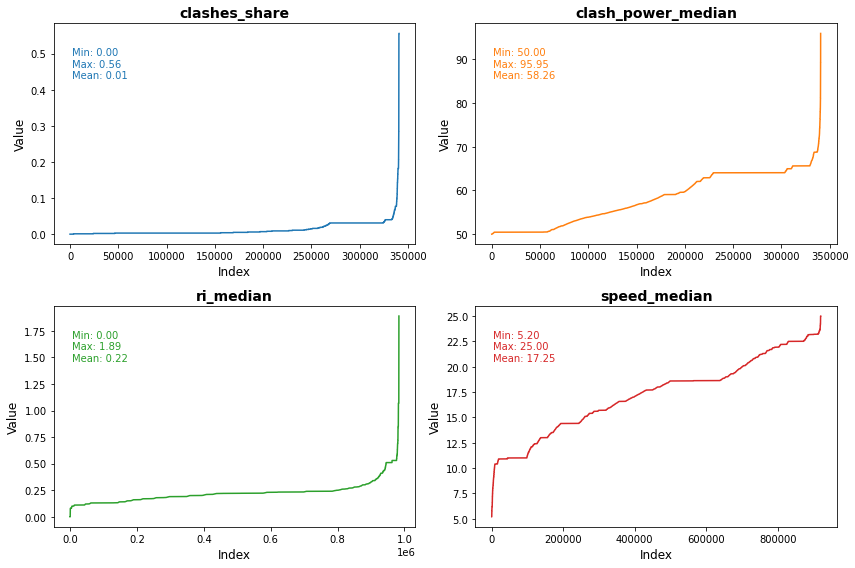

In [11]:
roads = pd.read_csv('df.csv')
df = pd.read_csv("all_roads.csv")
df = df.drop(columns="Unnamed: 0")

# Create subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Customize colors for better visibility on GitHub
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Plot the graphs
for i, column in enumerate(columns):
    # Sort the values in the column
    sorted_values = df[column].sort_values().reset_index(drop=True)

    # Calculate the row and column position for the current graph
    row = i // 2
    col = i % 2

    # Plot the graph with customizations
    axes[row, col].plot(sorted_values, color=colors[i])
    axes[row, col].set_title(column, fontsize=14, fontweight="bold")
    axes[row, col].set_xlabel("Index", fontsize=12)
    axes[row, col].set_ylabel("Value", fontsize=12)

    # Add annotations for minimum, maximum, and mean values
    axes[row, col].annotate(
        f"Min: {sorted_values.min():.2f}\nMax: {sorted_values.max():.2f}\nMean: {sorted_values.mean():.2f}",
        xy=(0.05, 0.75),
        xycoords="axes fraction",
        fontsize=10,
        color=colors[i],
    )

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()


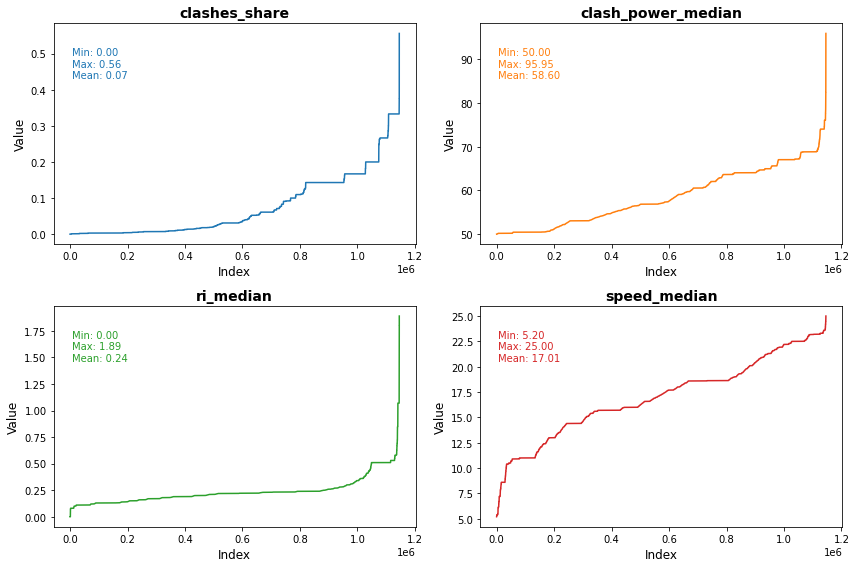

In [12]:
import matplotlib.pyplot as plt

# Create subplots with a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Customize colors for better visibility on GitHub
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Plot the graphs
for i, column in enumerate(columns):
    # Sort the values in the column
    sorted_values = roads[column].sort_values().reset_index(drop=True)

    # Calculate the row and column position for the current graph
    row = i // 2
    col = i % 2

    # Plot the graph with customizations
    axes[row, col].plot(sorted_values, color=colors[i])
    axes[row, col].set_title(column, fontsize=14, fontweight="bold")
    axes[row, col].set_xlabel("Index", fontsize=12)
    axes[row, col].set_ylabel("Value", fontsize=12)

    # Add annotations for minimum, maximum, and mean values
    axes[row, col].annotate(
        f"Min: {sorted_values.min():.2f}\nMax: {sorted_values.max():.2f}\nMean: {sorted_values.mean():.2f}",
        xy=(0.05, 0.75),
        xycoords="axes fraction",
        fontsize=10,
        color=colors[i],
    )

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()
